### Machine Learning Model to outperform S&P 500

### Use logistic regression

- Independednt variables: logged returns (t - 1, t - 2, ....)
- Dependent variable: Up (=1), Down (=0)
- Probabilistic model: If the predicted probability is above 0.5, the model will label as 1 ('UP'),
                       If below 0.5, the model will label as 0 ('DOWN')

In [1]:
import yfinance as yf 
import numpy as np 
from sklearn.linear_model import LogisticRegression

In [2]:
#sp500 data since 2010
df = yf.download('^GSPC',start='2010-01-01')


[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [4]:
#relative change of the cdaily lose price
df['ret'] = df.Close.pct_change() 

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,ret
Date,,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,NaN
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882


In [6]:
#function to calculate lagged returns 
def lagit(dr,lags):
    for i in range(1,lags+1):
        df['Lag_'+str(i)] = df['ret'].shift(i)
    return ['Lag_'+str(i) for i in range(1,lags+1)]

In [7]:
lagit(df,2)

['Lag_1', 'Lag_2']

In [8]:
#check directionality of the fluctuation for return, if positive = 1, if negative = 0
df['direction'] = np.where(df.ret > 0, 1, 0)

In [9]:
df.direction.value_counts()

1    1797
0    1519
Name: direction, dtype: int64

In [10]:
#independent variables as features 
features = lagit(df,3)

In [11]:
features

['Lag_1', 'Lag_2', 'Lag_3']

In [12]:
#drop non values
df.dropna(inplace=True)

In [13]:
#filter data frame by the features (independent variables)
dx = df[features]

In [14]:
#variable as market directionality 
y = df['direction']

In [15]:
#initiate model with balanced class weight 
model = LogisticRegression(class_weight='balanced')

In [16]:
model.fit(dx,y)

LogisticRegression(class_weight='balanced')

In [17]:
#data frame column for predictions based on linear regression 
df['prediction_LR'] = model.predict(dx)

In [18]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,ret,Lag_1,Lag_2,direction,Lag_3,prediction_LR
Date,,,,,,,,,,,,
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,0.004001,0.000546,1,0.003116,0
2010-01-11,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4255780000,0.001747,0.002882,0.004001,1,0.000546,0
2010-01-12,1143.810059,1143.810059,1131.770020,1136.219971,1136.219971,4716160000,-0.009381,0.001747,0.002882,0,0.004001,0
2010-01-13,1137.310059,1148.400024,1133.180054,1145.680054,1145.680054,4170360000,0.008326,-0.009381,0.001747,1,0.002882,1
2010-01-14,1145.680054,1150.410034,1143.800049,1148.459961,1148.459961,3915200000,0.002426,0.008326,-0.009381,1,0.001747,0


In [19]:
df['strat'] = df['prediction_LR'] * df.ret

In [20]:
#accumulate returns based on strategy
(df[['strat','ret']] + 1).cumprod() -1 

,strat,ret
Date,,
2010-01-08,0.000000,0.002882
2010-01-11,0.000000,0.004634
2010-01-12,0.000000,-0.004791
2010-01-13,0.008326,0.003495
2010-01-14,0.008326,0.005930
...,...,...
2023-03-01,3.898590,2.461001
2023-03-02,3.935732,2.487243
2023-03-03,3.935732,2.543554


<AxesSubplot:xlabel='Date'>

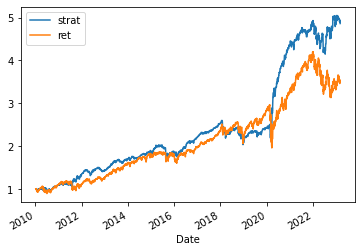

In [21]:
(df[['strat','ret']] + 1).cumprod().plot()

In [22]:
#train data set
from sklearn.model_selection import train_test_split

In [23]:
dx_train, dx_test, y_train, y_test = train_test_split(dx,y,test_size=0.3,shuffle=False)

In [24]:
dx_train

,Lag_1,Lag_2,Lag_3
Date,,,
2010-01-08,0.004001,0.000546,0.003116
2010-01-11,0.002882,0.004001,0.000546
2010-01-12,0.001747,0.002882,0.004001
2010-01-13,-0.009381,0.001747,0.002882
2010-01-14,0.008326,-0.009381,0.001747
...,...,...,...
2019-03-20,-0.000131,0.003706,0.004985
2019-03-21,-0.002944,-0.000131,0.003706
2019-03-22,0.010852,-0.002944,-0.000131


In [25]:
model.fit(dx_train,y_train)

LogisticRegression(class_weight='balanced')

In [26]:
dx_test['prediction_LR'] = model.predict(dx_test)

<ipython-input-26-d38cce0399b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dx_test['prediction_LR'] = model.predict(dx_test)


In [27]:
dx_test['ret'] = df.ret[dx_test.index[0]:]

<ipython-input-27-05fe5d33a90e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dx_test['ret'] = df.ret[dx_test.index[0]:]


In [28]:
dx_test['strat'] = dx_test['prediction_LR'] * dx_test.ret

<ipython-input-28-e8de8c8bf228>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dx_test['strat'] = dx_test['prediction_LR'] * dx_test.ret


In [29]:
dx_test

,Lag_1,Lag_2,Lag_3,prediction_LR,ret,strat
Date,,,,,,
2019-03-27,0.007183,-0.000839,-0.018975,1,-0.004644,-0.004644
2019-03-28,-0.004644,0.007183,-0.000839,1,0.003589,0.003589
2019-03-29,0.003589,-0.004644,0.007183,0,0.006734,0.000000
2019-04-01,0.006734,0.003589,-0.004644,0,0.011569,0.000000
2019-04-02,0.011569,0.006734,0.003589,0,0.000017,0.000000
...,...,...,...,...,...,...
2023-03-01,-0.003036,0.003073,-0.010538,1,-0.004725,-0.004725
2023-03-02,-0.004725,-0.003036,0.003073,1,0.007582,0.007582
2023-03-03,0.007582,-0.004725,-0.003036,0,0.016148,0.000000


In [30]:
(dx_test[['strat','ret']]+1).cumprod() - 1

,strat,ret
Date,,
2019-03-27,-0.004644,-0.004644
2019-03-28,-0.001072,-0.001072
2019-03-29,-0.001072,0.005656
2019-04-01,-0.001072,0.017290
2019-04-02,-0.001072,0.017307
...,...,...
2023-03-01,1.253692,0.401968
2023-03-02,1.270780,0.412598
2023-03-03,1.270780,0.435408


<AxesSubplot:xlabel='Date'>

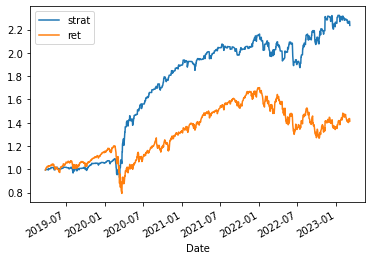

In [31]:
(dx_test[['strat','ret']]+1).cumprod().plot()